In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'NWL'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,1526,-952,574,49,199,1248,709,2426,2546,...,674,391,7,1891,2085,4830,291,-61,278.9,2015-02-14
1,2015-03-31,1264,-777,488,57,215,1053,852,2422,2475,...,616,734,7,2045,2094,4909,-154,-51,271.5,2015-04-27
2,2015-06-30,1561,-940,621,148,239,1304,936,2753,2492,...,757,777,6,2307,2081,5179,103,-35,271.5,2015-07-27
3,2015-09-30,1530,-931,599,134,266,1171,899,2586,2496,...,679,631,6,2140,2097,5009,340,-69,271.5,2015-10-27
4,2015-12-31,1561,-964,597,-80,275,1251,722,2494,2791,...,642,389,0,1988,2669,5398,278,-57,271.5,2016-02-14


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-12-31,2024-02-14,414.10,2076,-1418,658,-86,332,1195,1531,...,2488,12163,1003,0,329,2897,4575,9051,251,-63
37,2024-03-31,2024-04-27,416.05,1653,-1141,512,-9,372,958,1695,...,2447,12100,1038,0,429,2956,4558,9024,32,-59
38,2024-06-30,2024-07-27,416.05,2033,-1327,706,45,382,1072,1639,...,2412,12048,1079,0,983,3502,4059,8968,32,-53
39,2024-09-30,2024-10-25,416.00,1947,-1268,679,-198,494,931,1652,...,2155,11773,1047,0,869,3402,4092,8913,282,-51
40,2024-12-31,2025-02-17,415.50,1949,-1298,651,-54,198,878,1400,...,2008,11004,891,0,87,2437,4508,8253,150,-96


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-14,414.10,2076,-1418,658,-86,332,1195,1531,...,12163,1003,0,329,2897,4575,9051,251,-63,1
37,2024-03-31,2024-04-27,416.05,1653,-1141,512,-9,372,958,1695,...,12100,1038,0,429,2956,4558,9024,32,-59,1
38,2024-06-30,2024-07-27,416.05,2033,-1327,706,45,382,1072,1639,...,12048,1079,0,983,3502,4059,8968,32,-53,1
39,2024-09-30,2024-10-25,416.00,1947,-1268,679,-198,494,931,1652,...,11773,1047,0,869,3402,4092,8913,282,-51,1
40,2024-12-31,2025-02-17,415.50,1949,-1298,651,-54,198,878,1400,...,11004,891,0,87,2437,4508,8253,150,-96,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-14,414.10,2076.0,-1418.0,658.0,-86.0,332.0,1195.0,1531.0,...,12163.0,1003.0,0.0,329.0,2897.0,4575.0,9051.0,251.0,-63.0,1
37,2024-03-31,2024-04-27,416.05,1653.0,-1141.0,512.0,-9.0,372.0,958.0,1695.0,...,12100.0,1038.0,0.0,429.0,2956.0,4558.0,9024.0,32.0,-59.0,1
38,2024-06-30,2024-07-27,416.05,2033.0,-1327.0,706.0,45.0,382.0,1072.0,1639.0,...,12048.0,1079.0,0.0,983.0,3502.0,4059.0,8968.0,32.0,-53.0,1
39,2024-09-30,2024-10-25,416.00,1947.0,-1268.0,679.0,-198.0,494.0,931.0,1652.0,...,11773.0,1047.0,0.0,869.0,3402.0,4092.0,8913.0,282.0,-51.0,1
40,2024-12-31,2025-02-17,415.50,1949.0,-1298.0,651.0,-54.0,198.0,878.0,1400.0,...,11004.0,891.0,0.0,87.0,2437.0,4508.0,8253.0,150.0,-96.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-02-16,27.443745,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.277054,0.722946,0.0,0.0,0.0,0.0,0.376147,0.03211,0.0,0.0
1,2015-02-23,26.875980,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.277054,0.722946,0.0,0.0,0.0,0.0,0.376147,0.03211,0.0,0.0
2,2015-03-02,26.496157,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.277054,0.722946,0.0,0.0,0.0,0.0,0.376147,0.03211,0.0,0.0
3,2015-03-09,26.530523,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.277054,0.722946,0.0,0.0,0.0,0.0,0.376147,0.03211,0.0,0.0
4,2015-03-16,27.300327,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.277054,0.722946,0.0,0.0,0.0,0.0,0.376147,0.03211,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-02-16,27.443745,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.0,0.376147,0.03211,0.0,0.0,inf,4.135095,inf,inf,inf
1,2015-02-23,26.875980,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.0,0.376147,0.03211,0.0,0.0,inf,4.049547,inf,inf,inf
2,2015-03-02,26.496157,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.0,0.376147,0.03211,0.0,0.0,inf,3.992317,inf,inf,inf
3,2015-03-09,26.530523,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.0,0.376147,0.03211,0.0,0.0,inf,3.997495,inf,inf,inf
4,2015-03-16,27.300327,2014-12-31,1526.0,0.0,6.636787,278.9,0.0,0.0,199.0,...,0.0,0.376147,0.03211,0.0,0.0,inf,4.113485,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

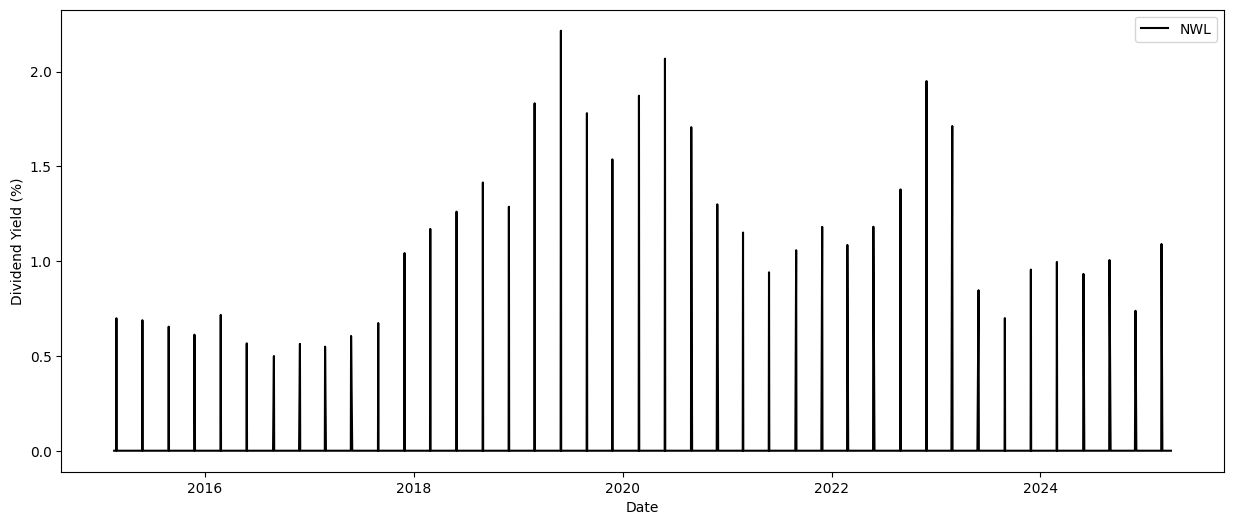

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


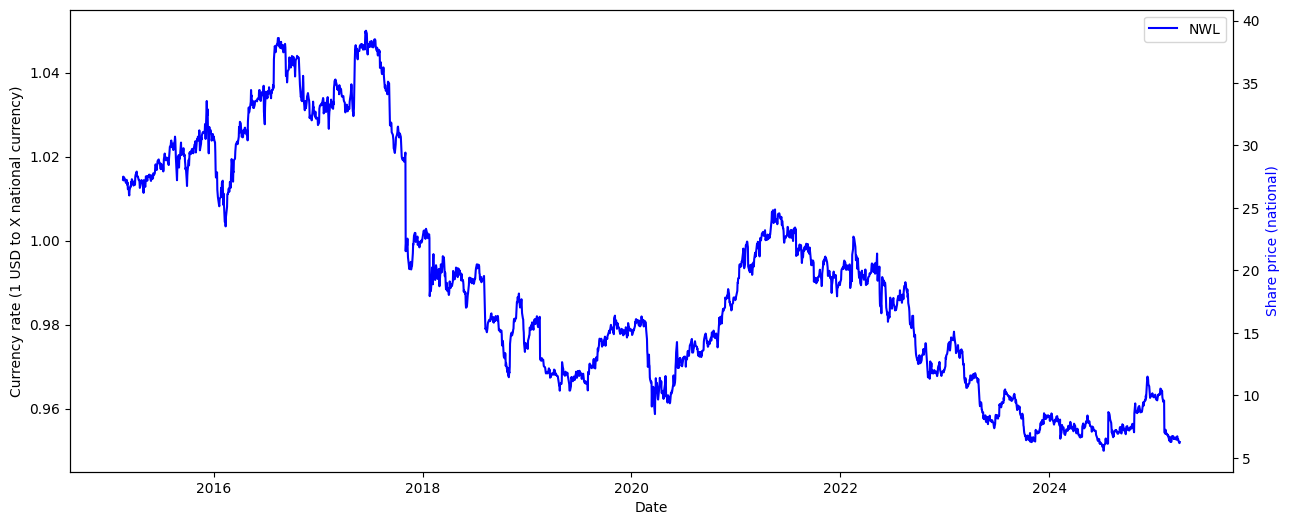

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

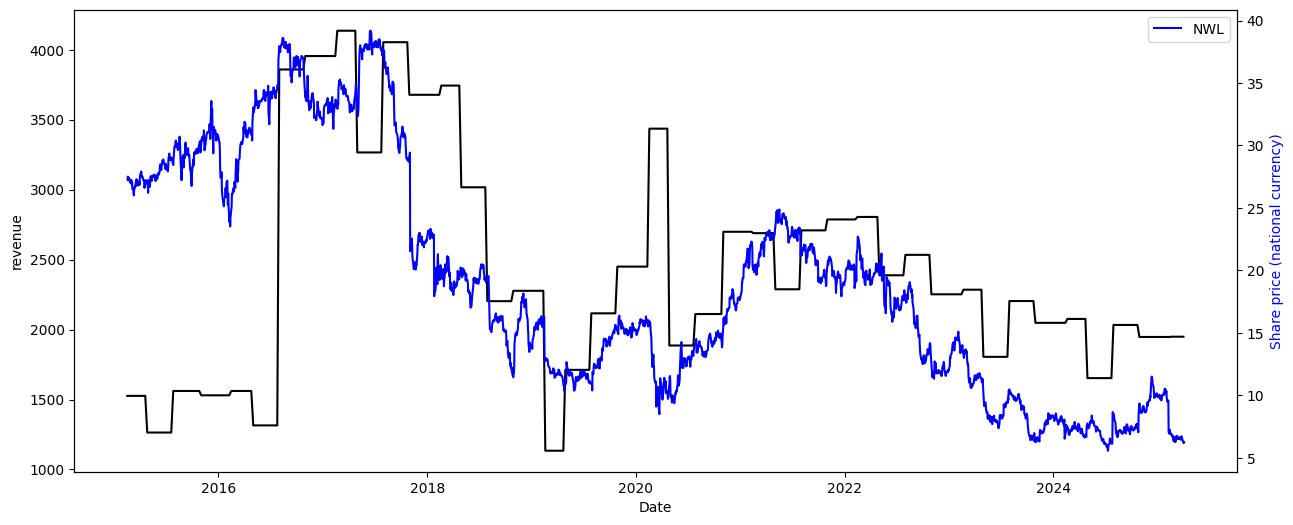

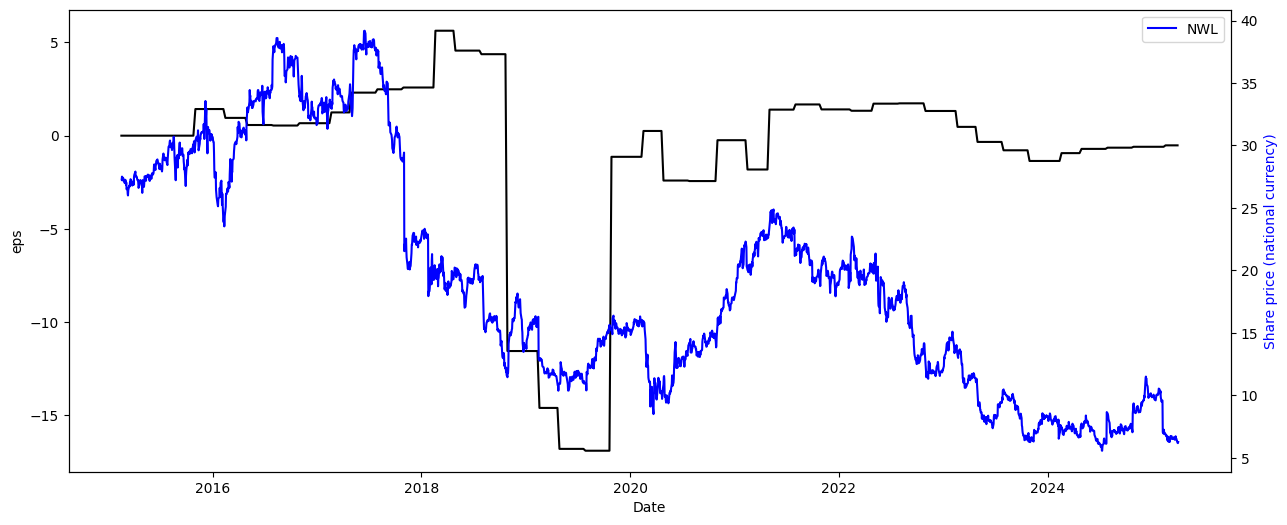

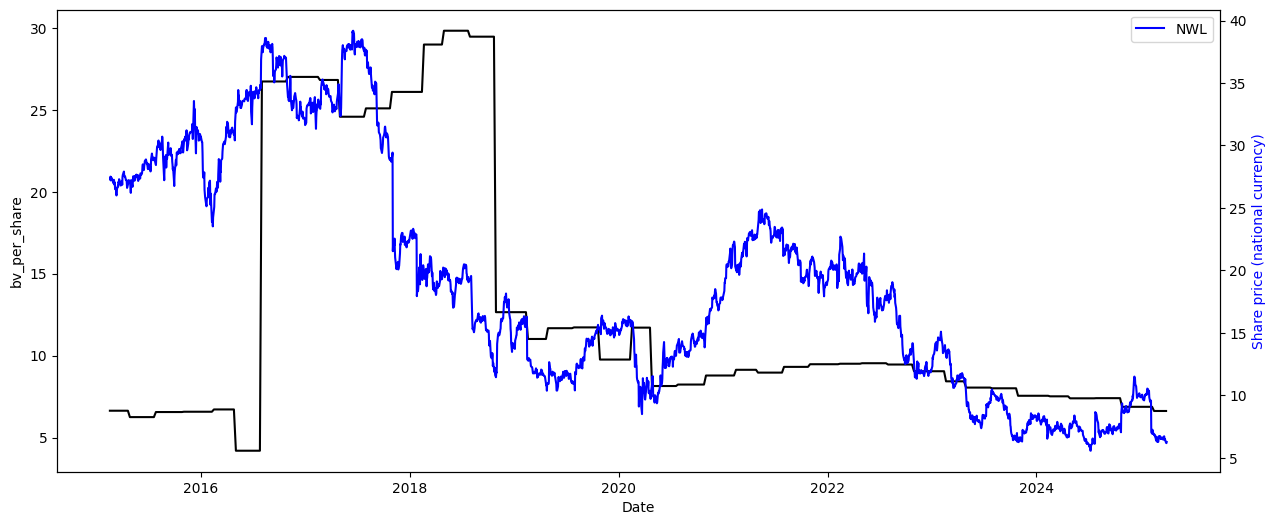

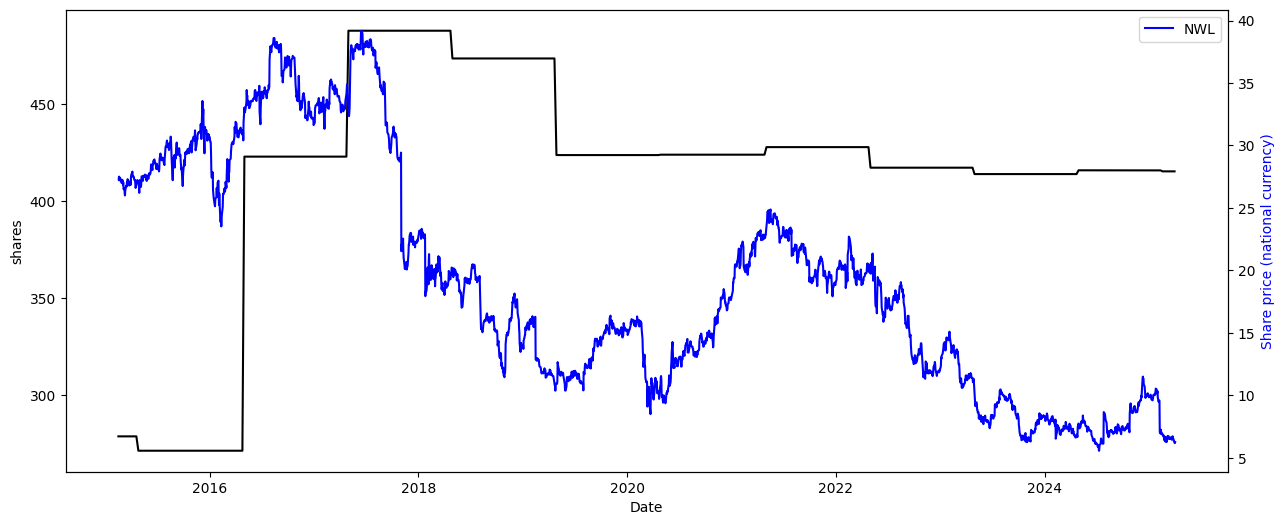

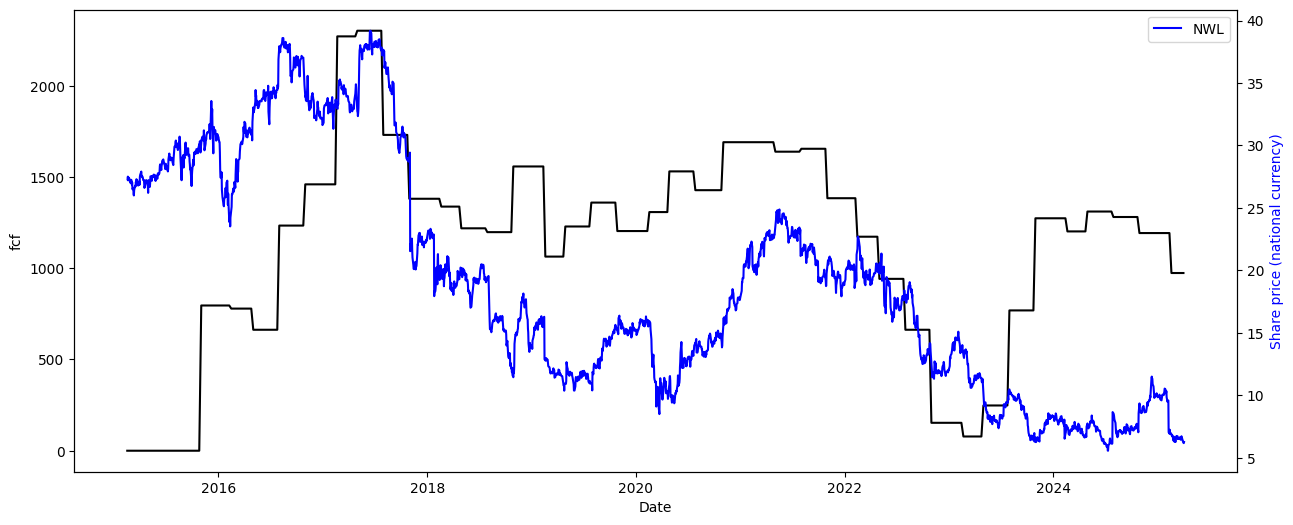

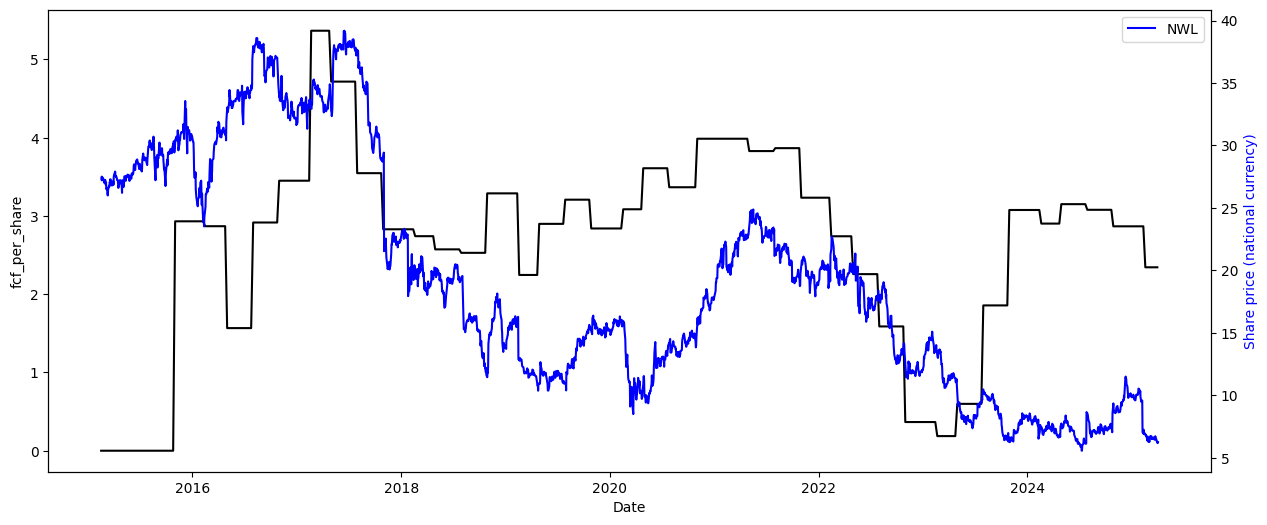

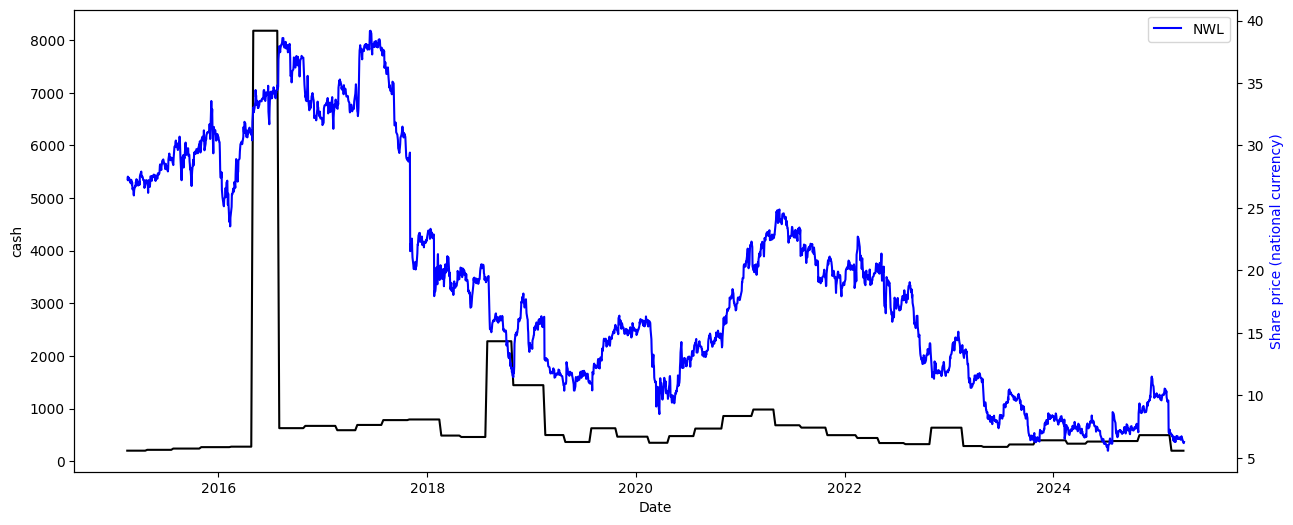

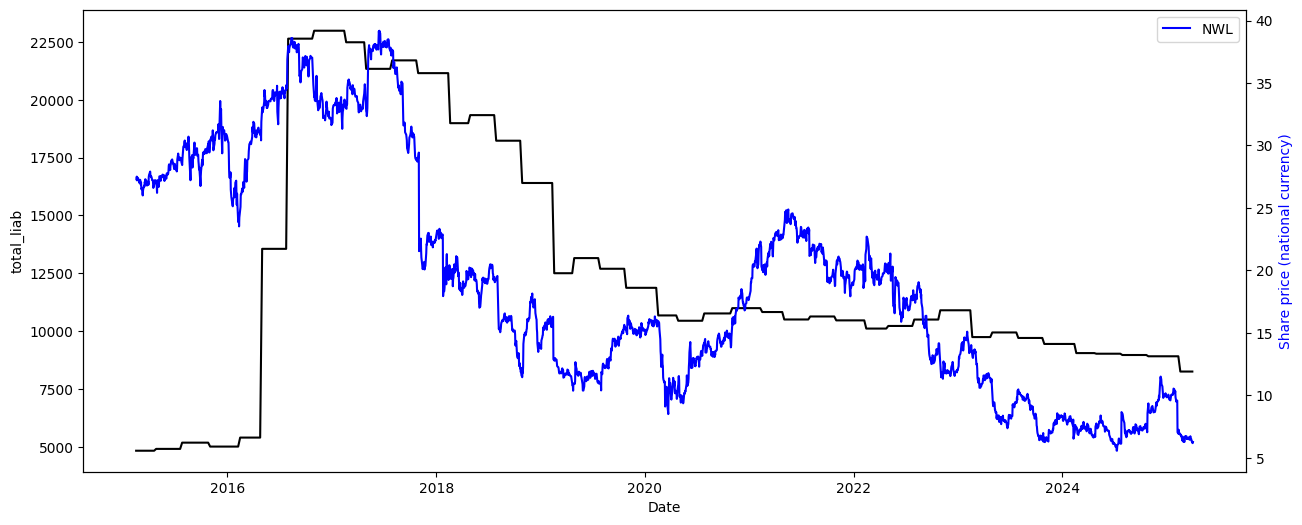

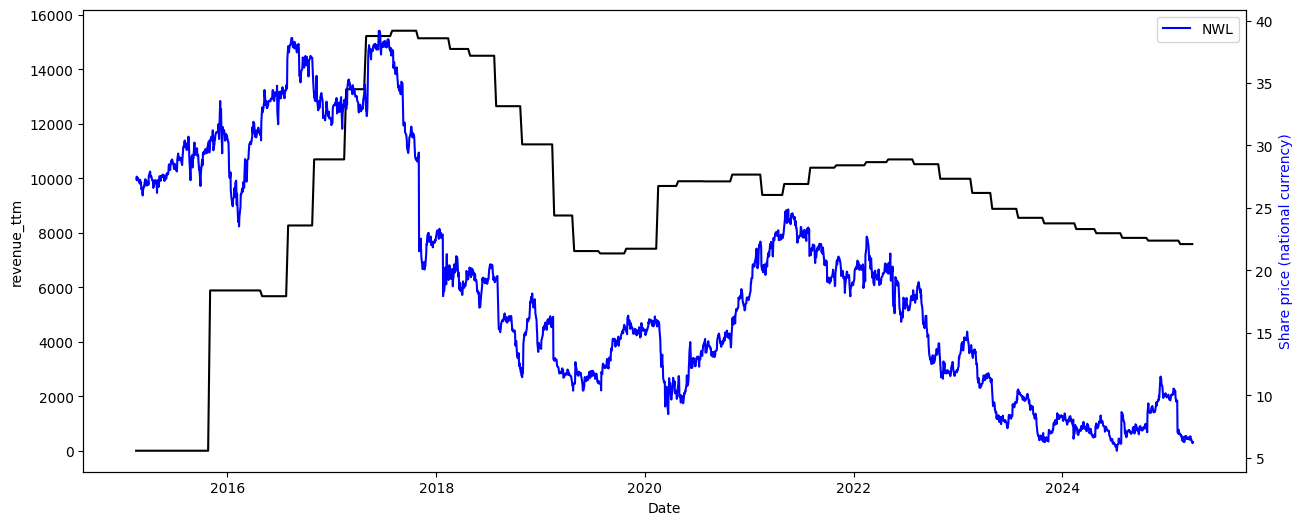

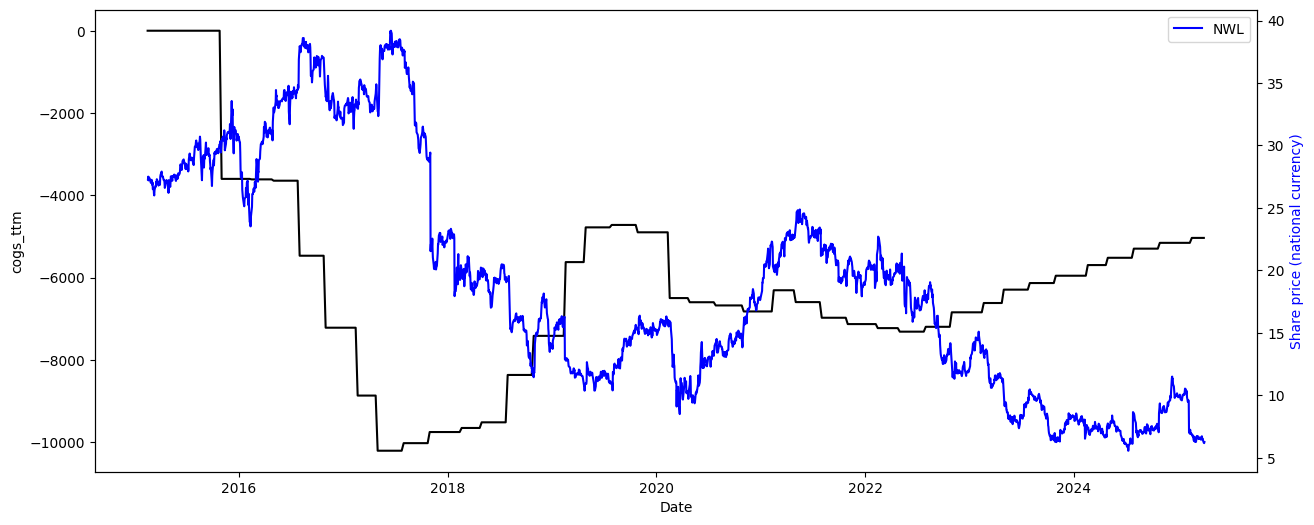

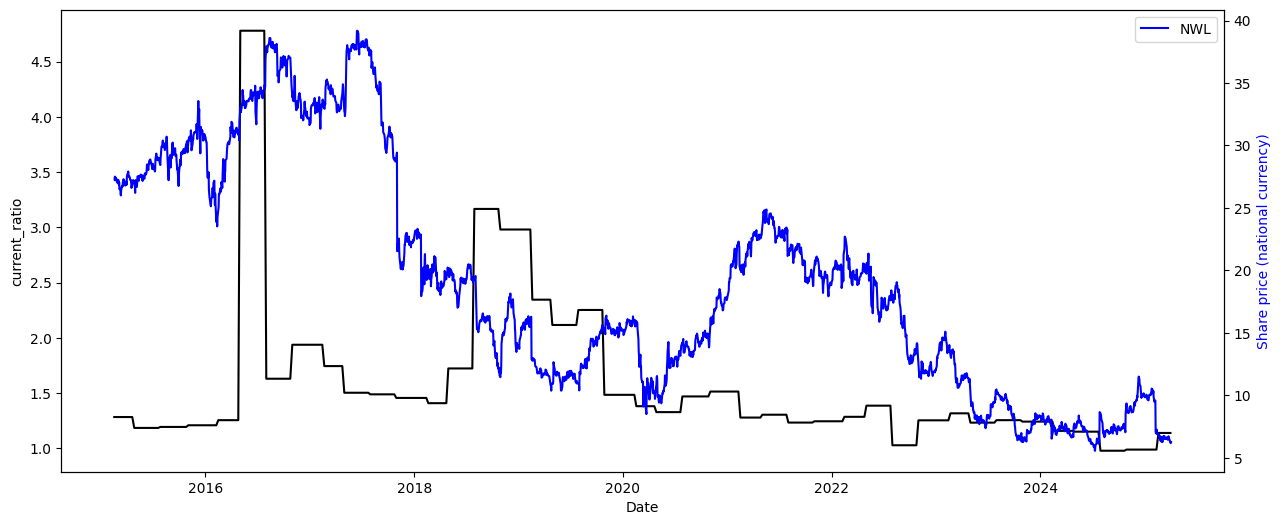

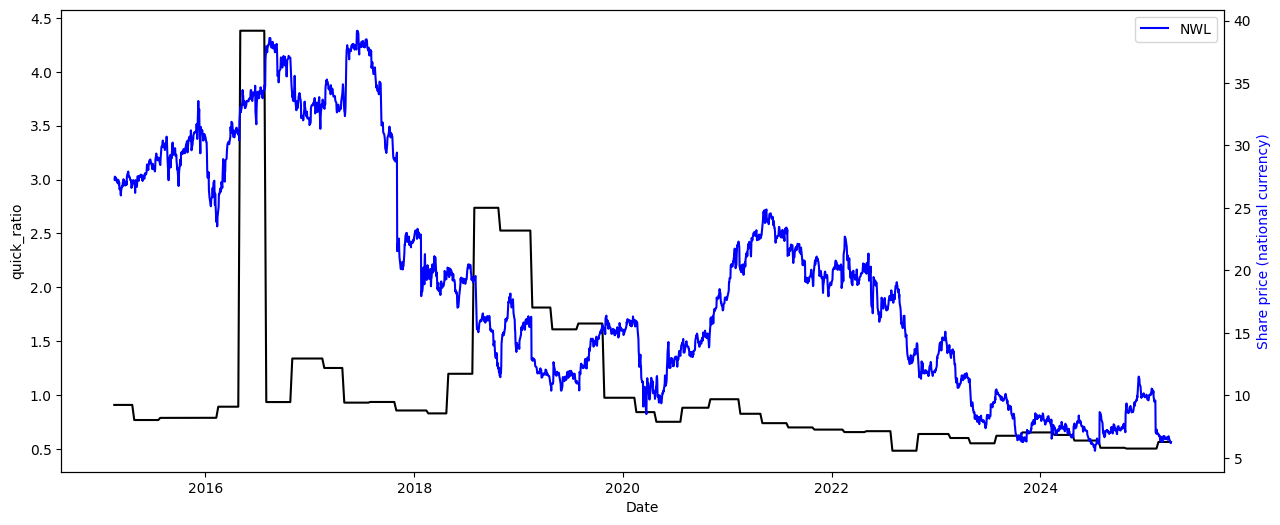

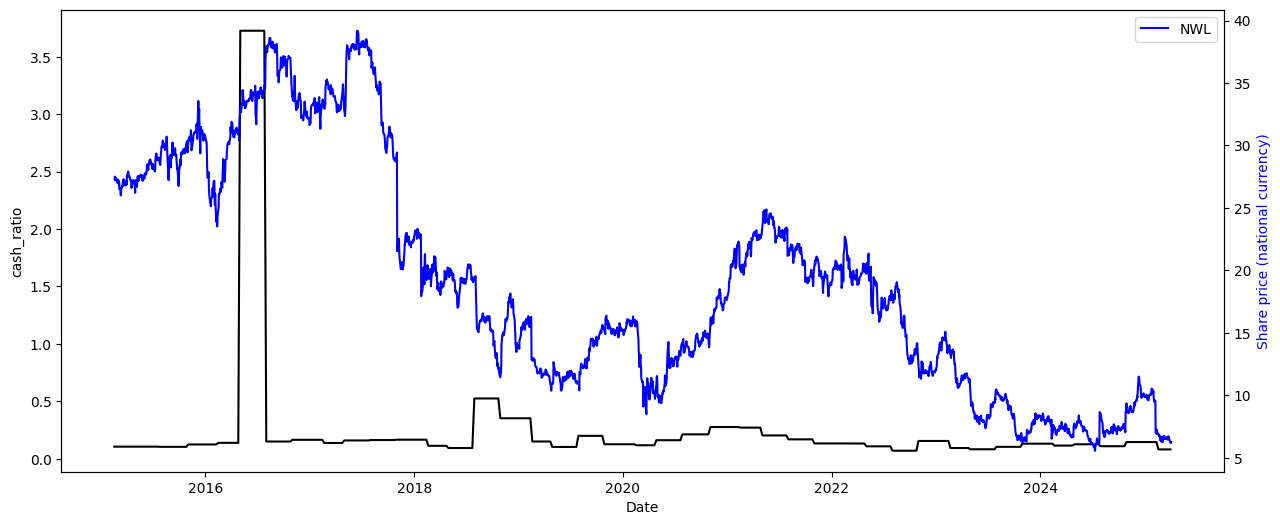

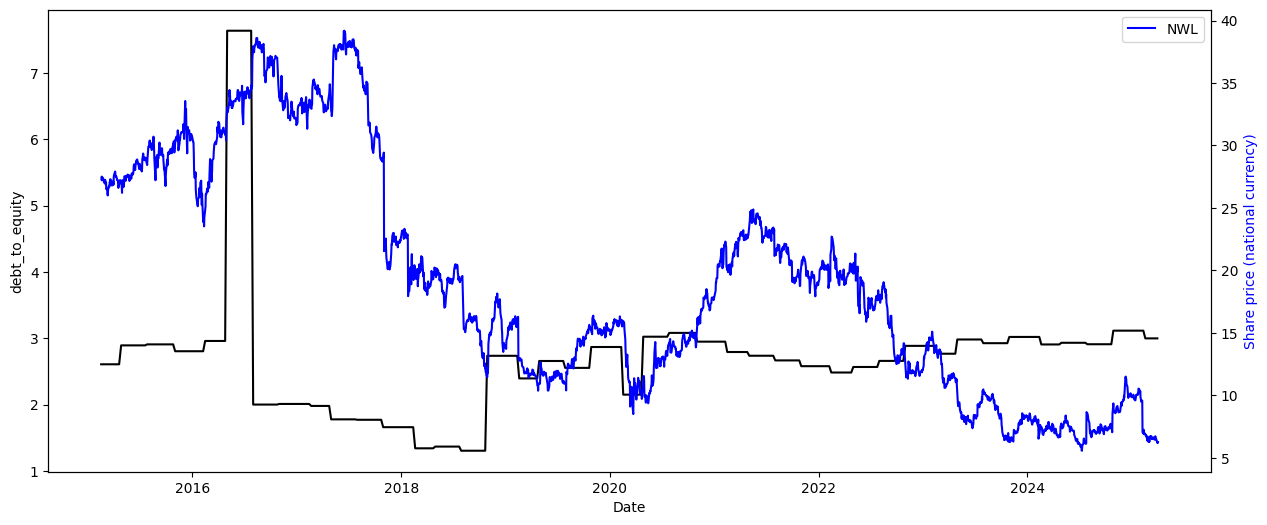

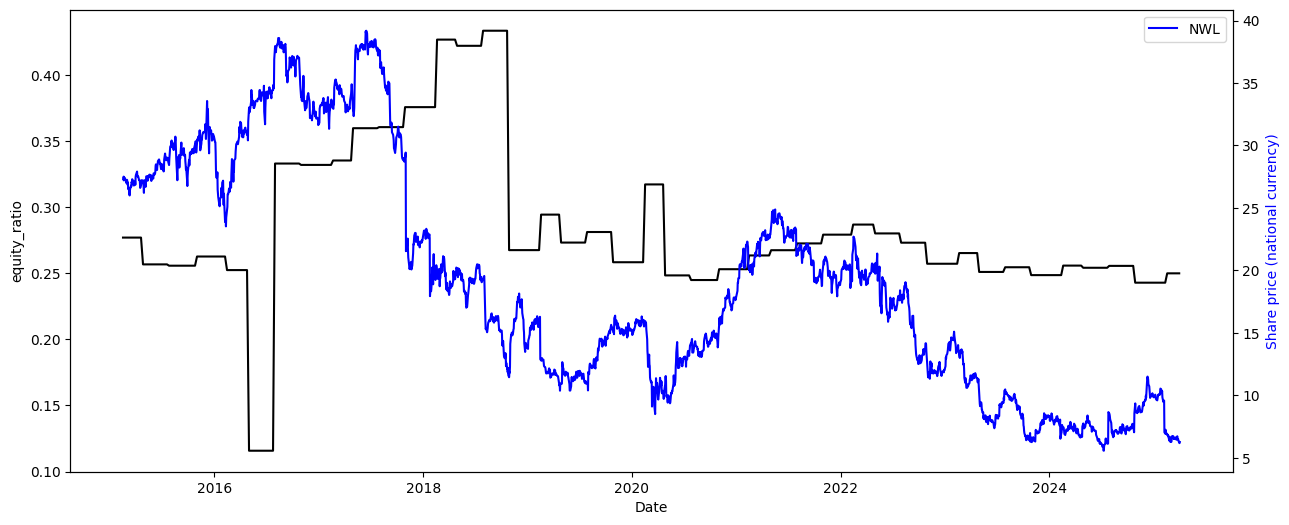

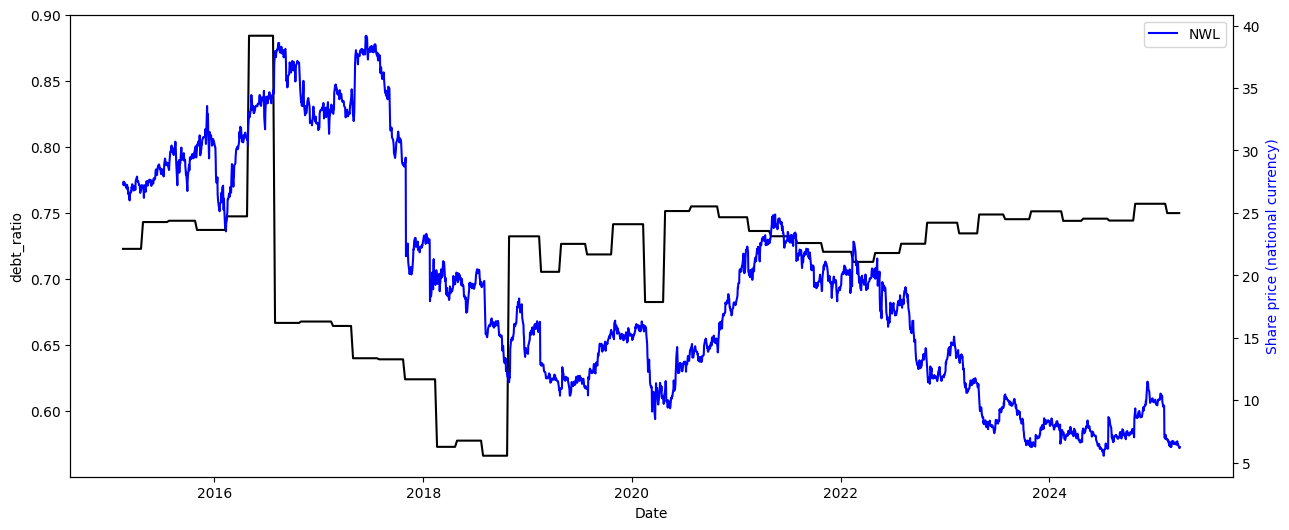

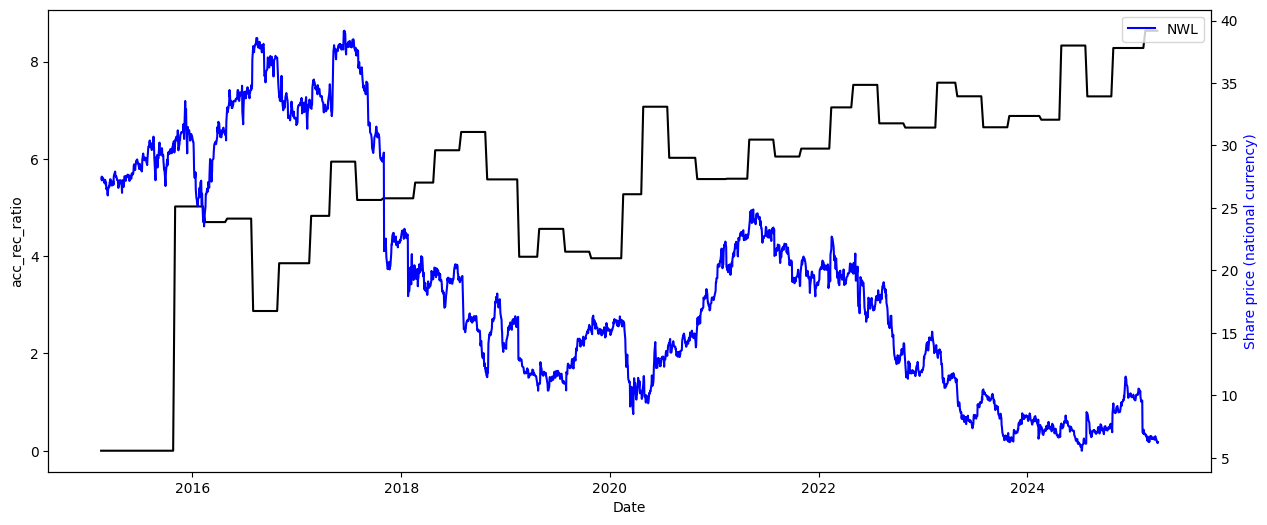

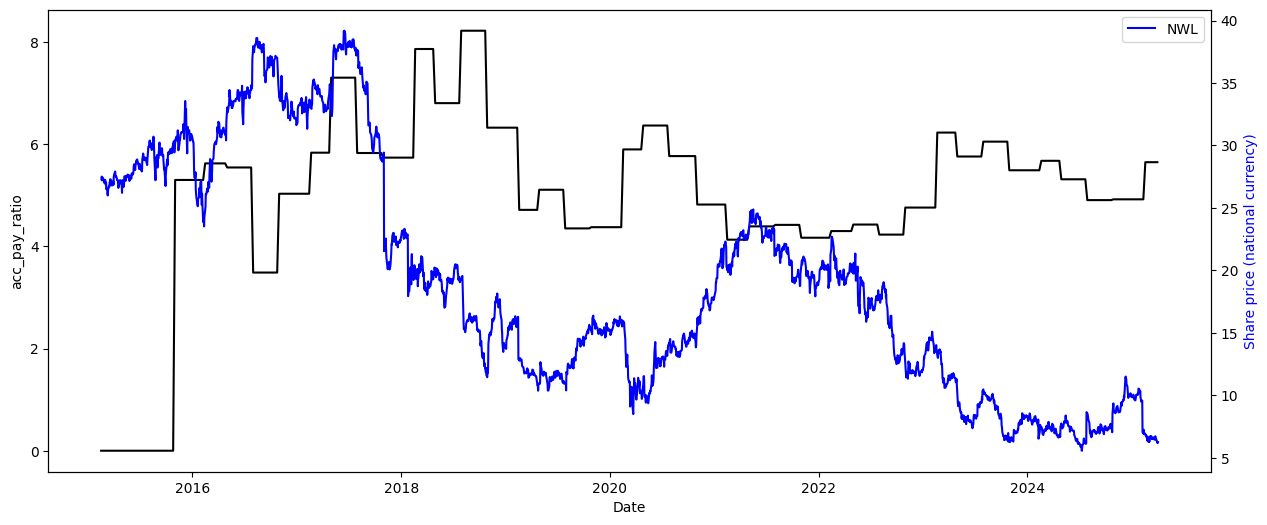

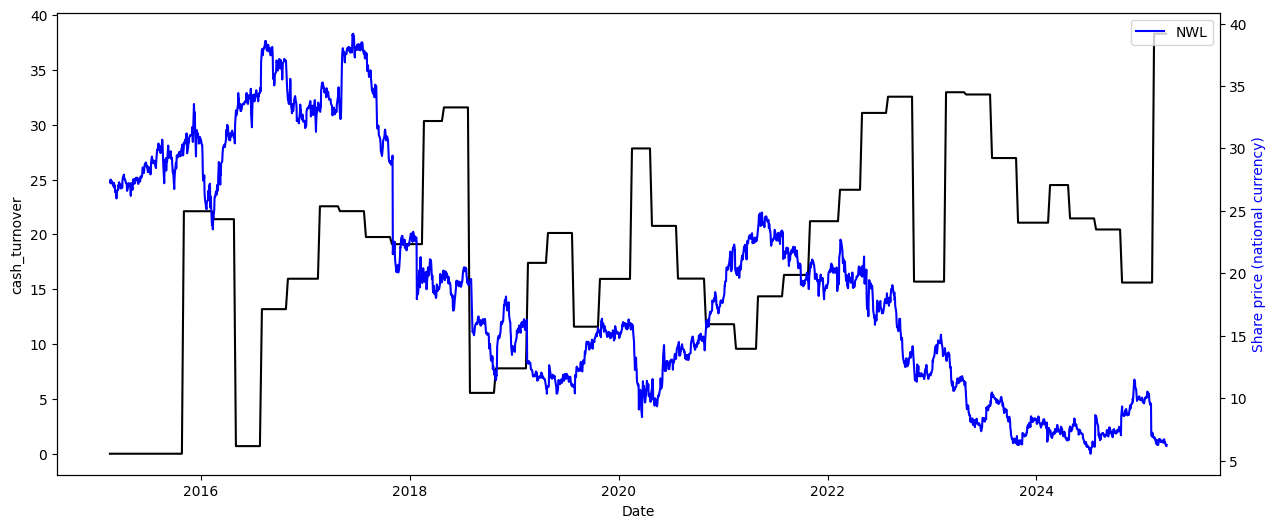

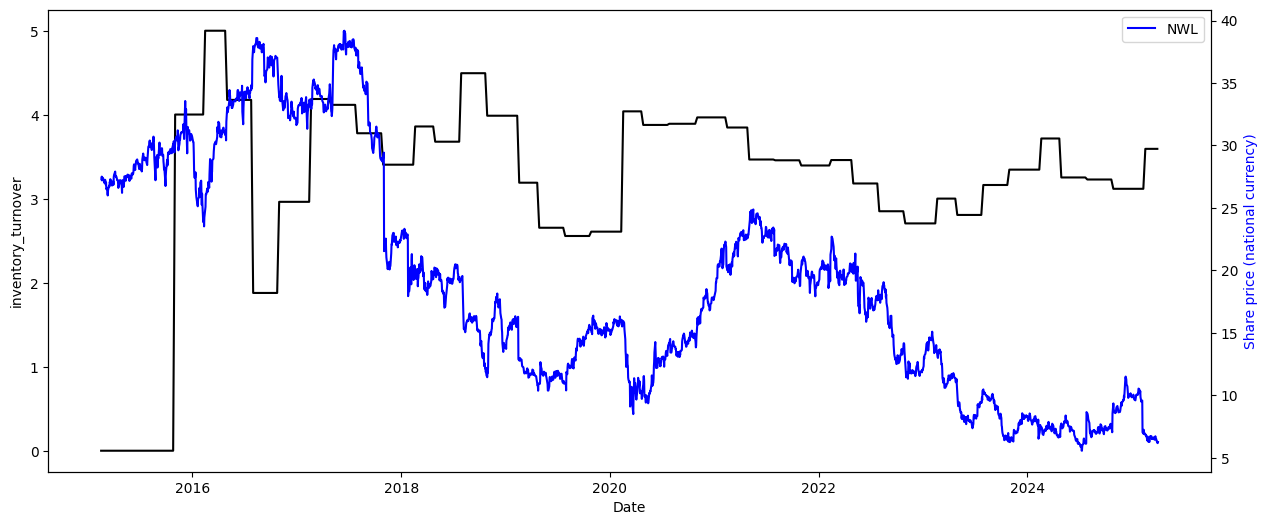

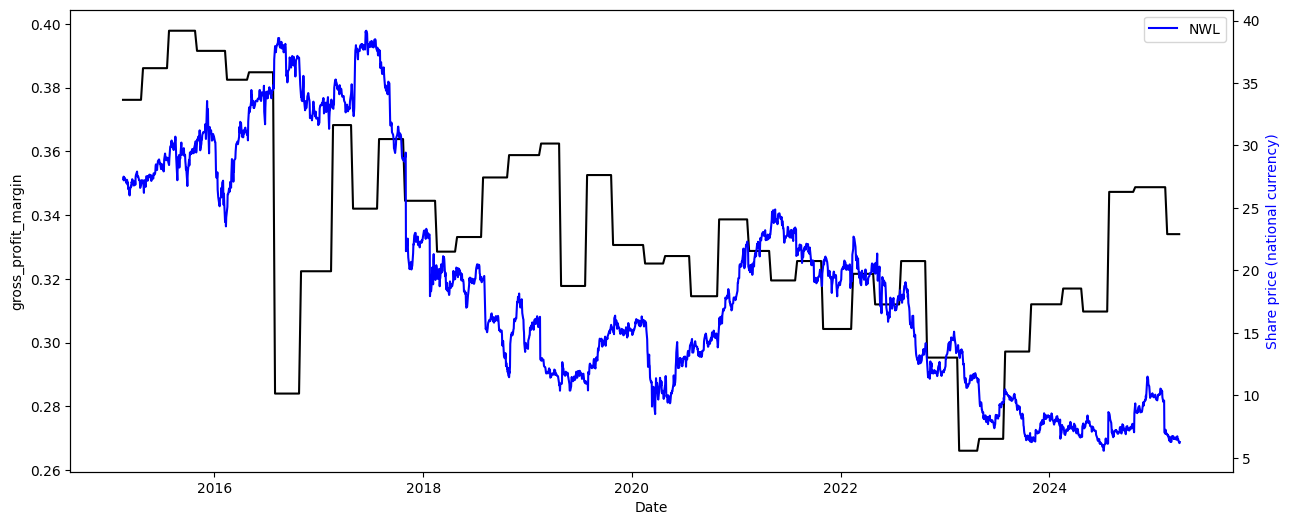

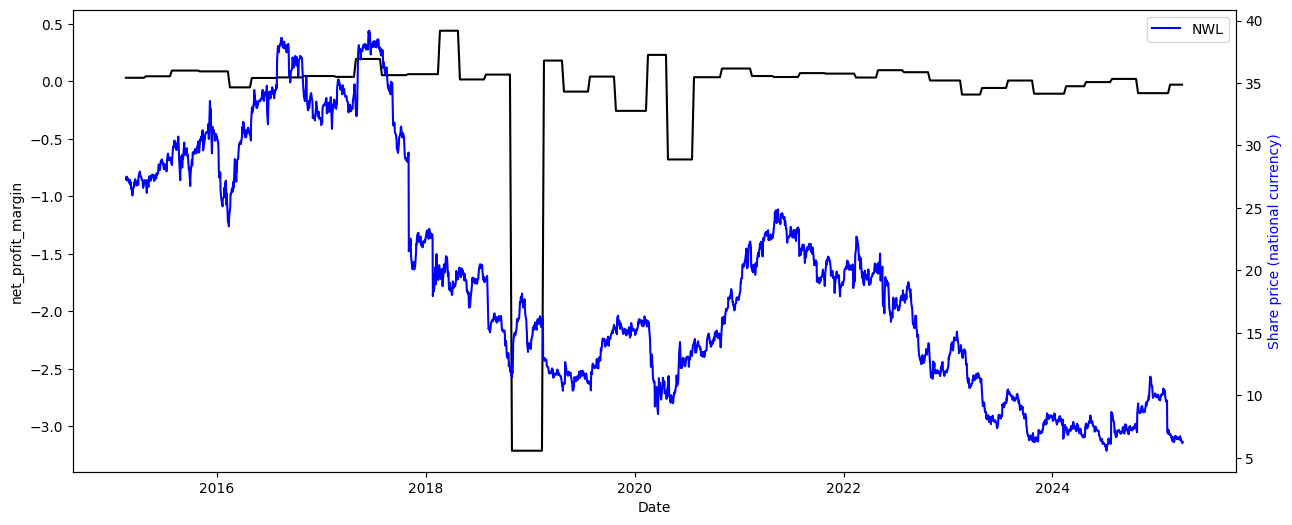

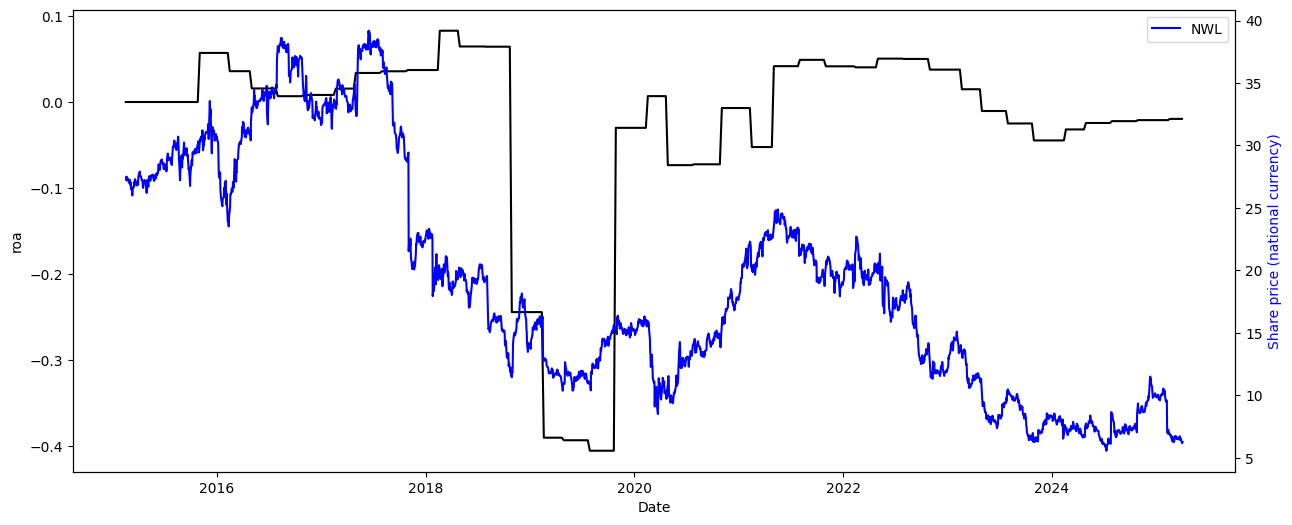

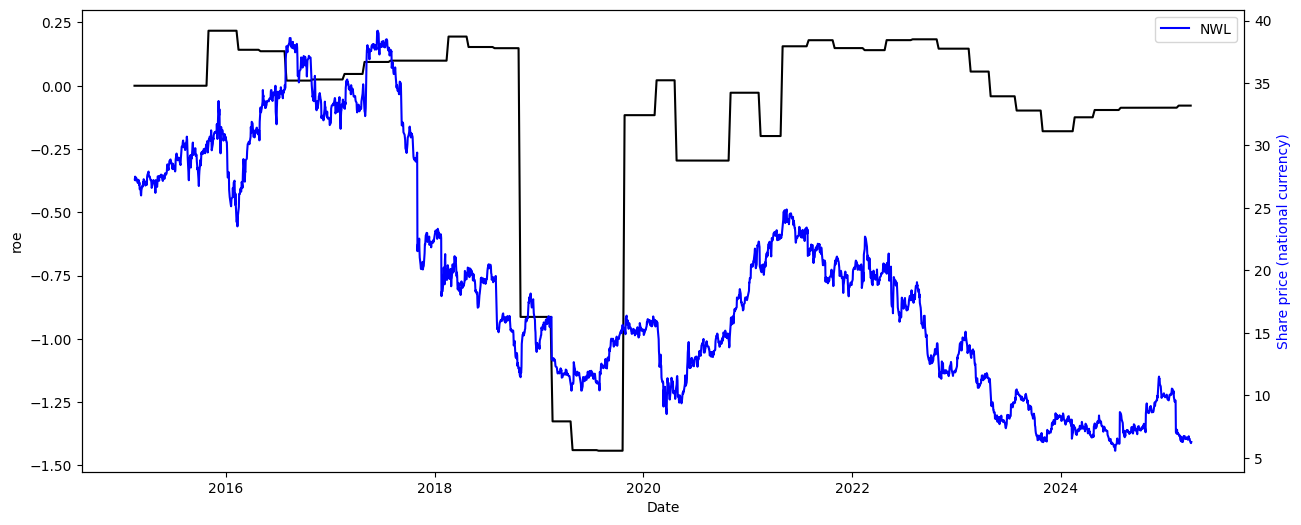

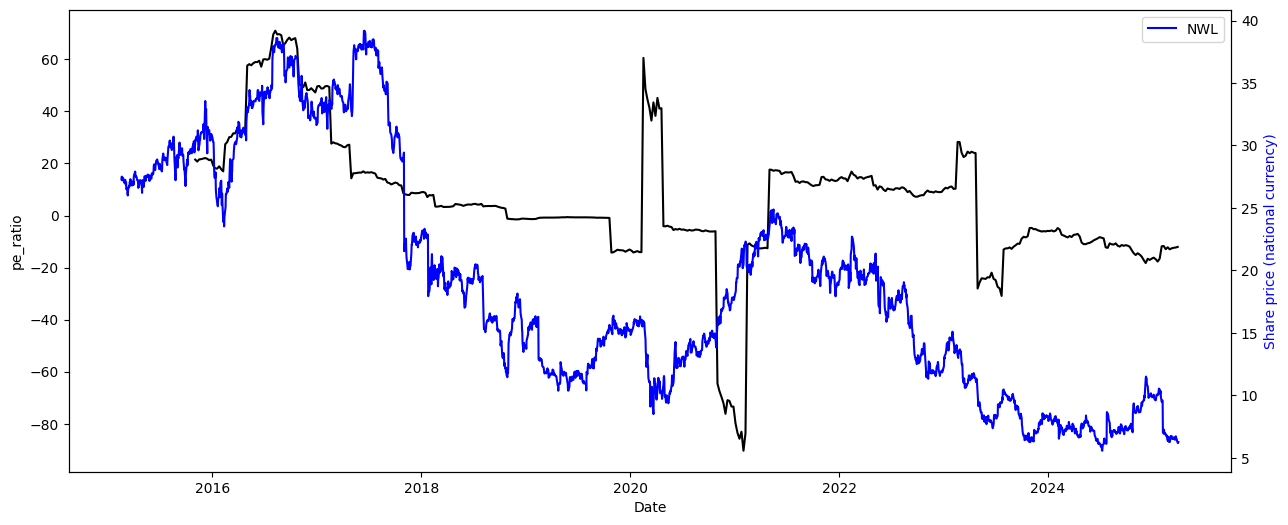

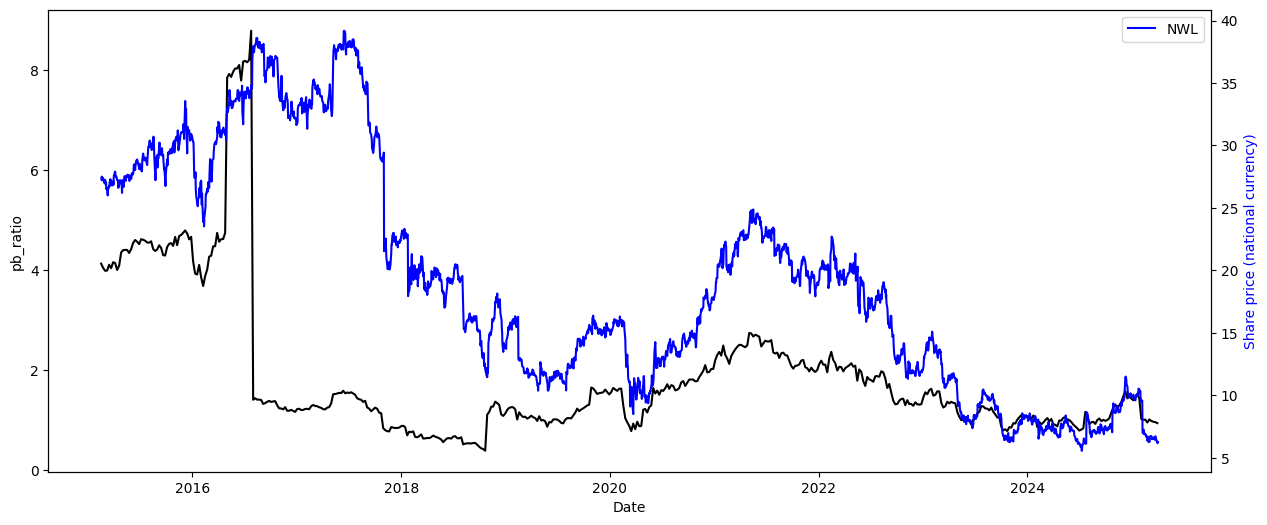

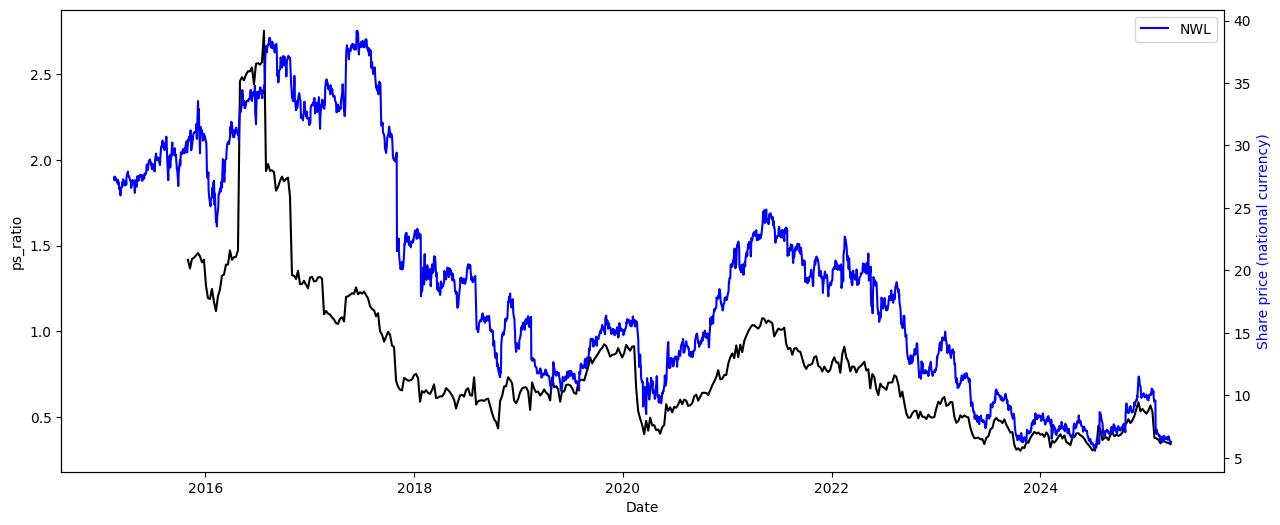

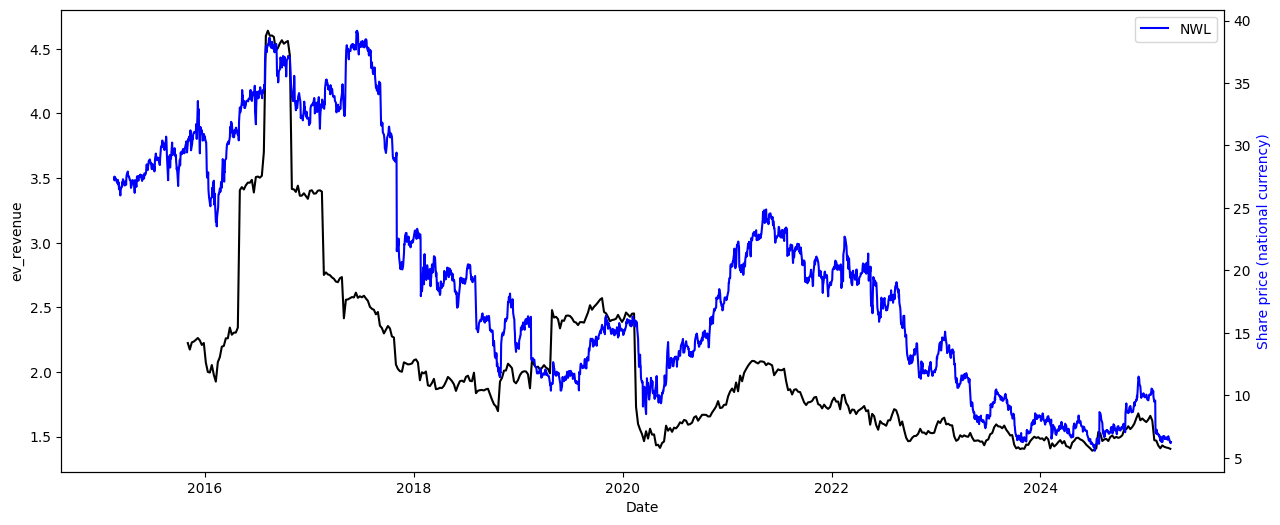

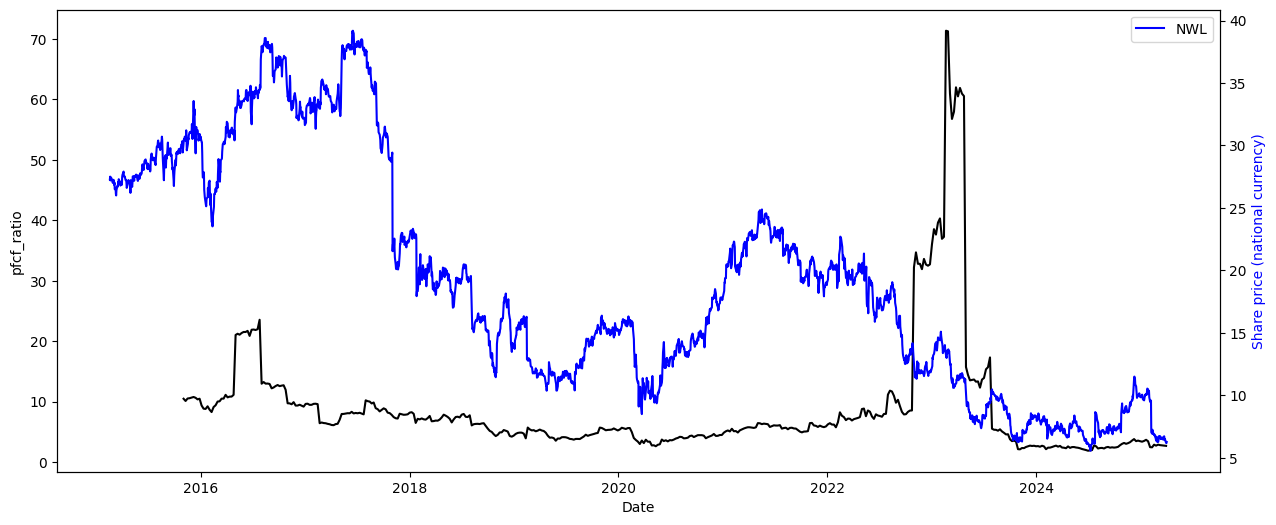

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

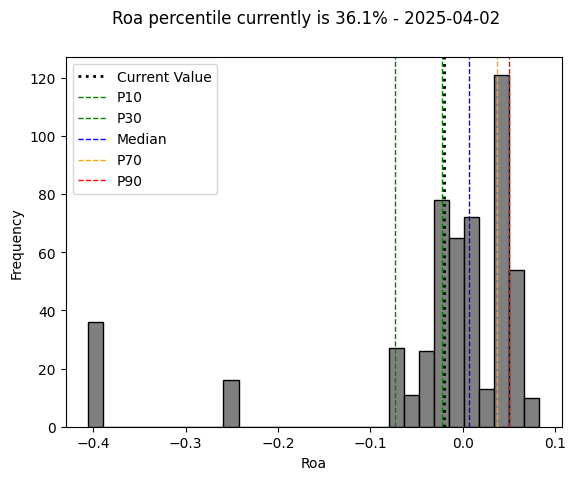

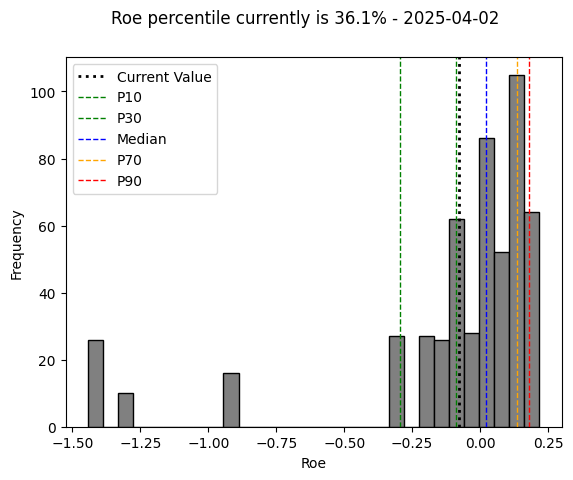

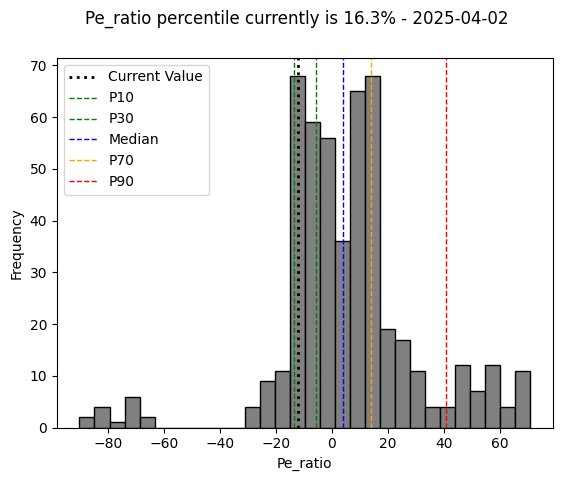

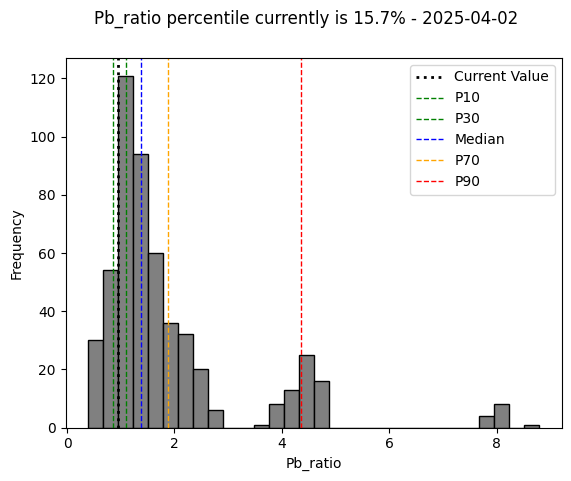

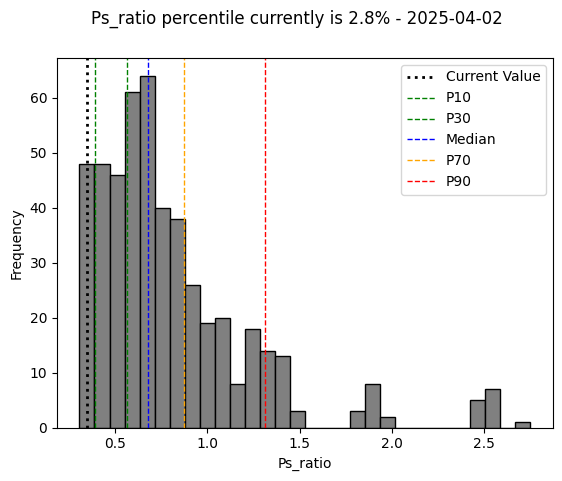

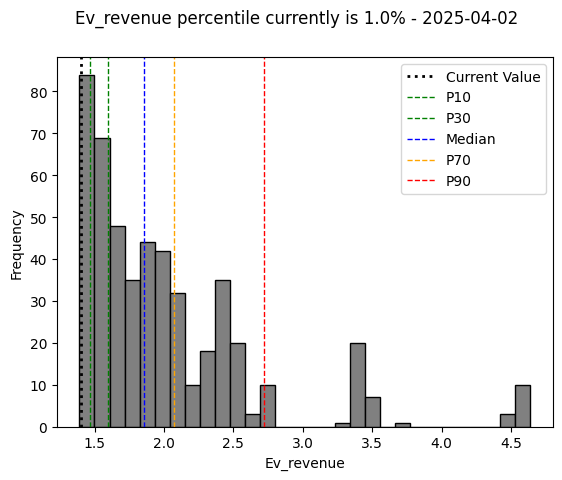

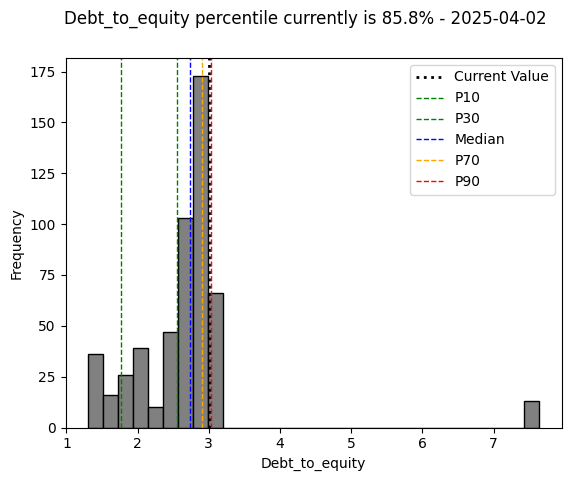

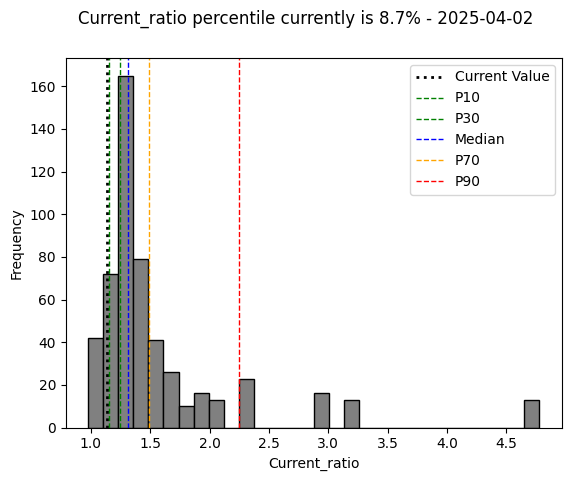

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.997311,0.202230,0.191031,0.155349,-0.062327,-0.069708,-0.307152
roe,0.997311,1.000000,0.221350,0.235373,0.188292,-0.047273,-0.021756,-0.298415
pe_ratio,0.202230,0.221350,1.000000,0.344948,0.636250,0.632451,0.080751,0.303972
pb_ratio,0.191031,0.235373,0.344948,1.000000,0.758847,0.331184,0.706144,0.320940
ps_ratio,0.155349,0.188292,0.636250,0.758847,1.000000,0.848678,0.419801,0.519734
ev_revenue,-0.062327,-0.047273,0.632451,0.331184,0.848678,1.000000,0.096288,0.464029
debt_to_equity,-0.069708,-0.021756,0.080751,0.706144,0.419801,0.096288,1.000000,0.447650
current_ratio,-0.307152,-0.298415,0.303972,0.320940,0.519734,0.464029,0.447650,1.000000


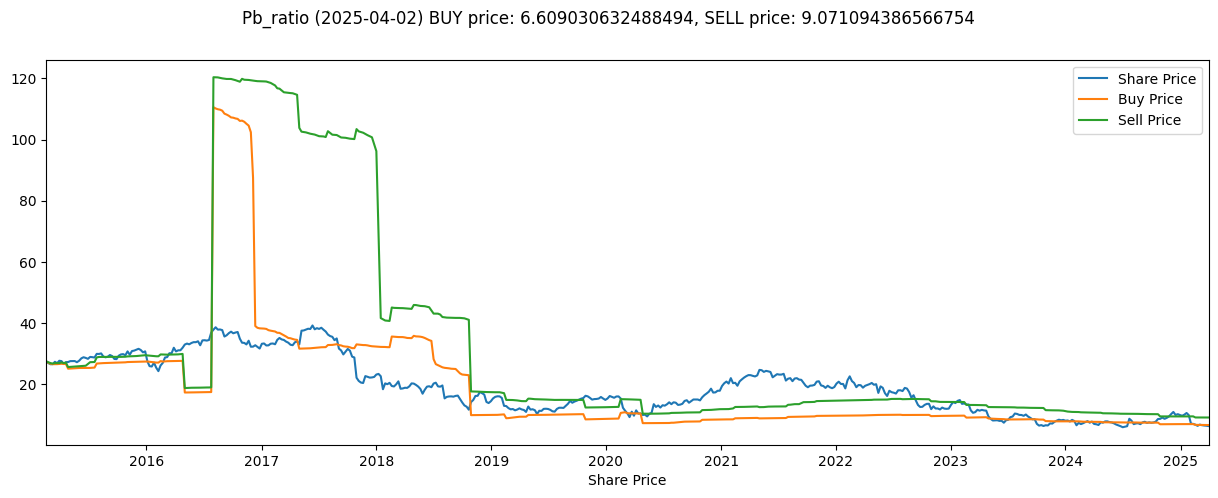

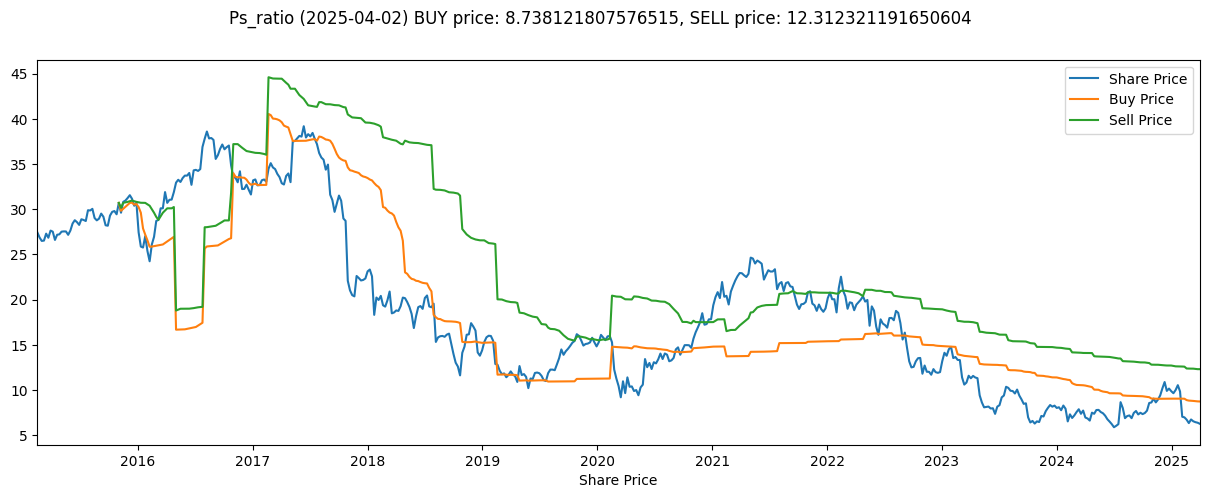

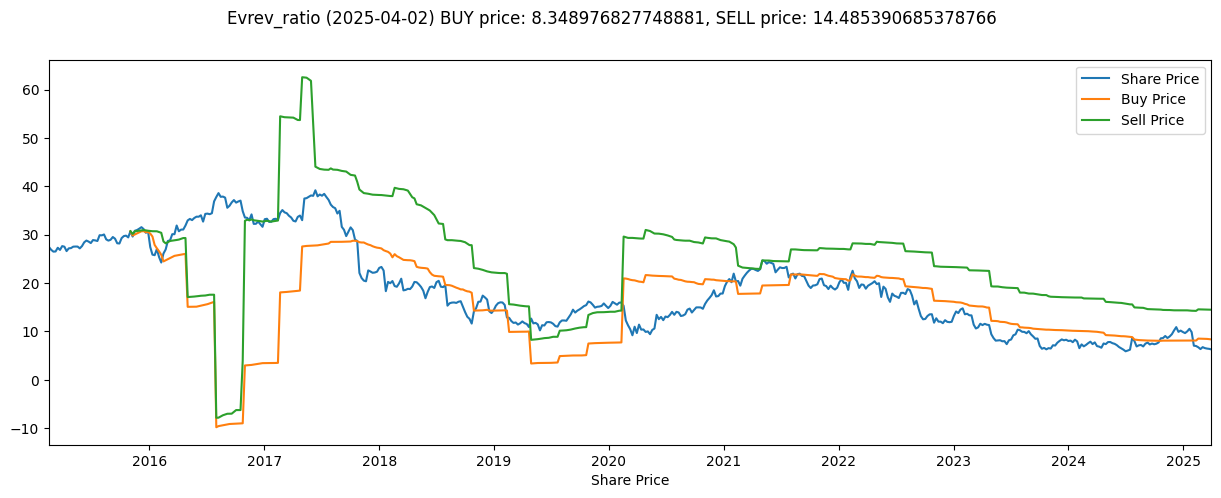

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)